In [183]:
# Peri Akiva, Arpit Shah
import os
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS as stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score
from sklearn.base import TransformerMixin
from collections import defaultdict
from sklearn.pipeline import Pipeline
from __future__ import division
from sklearn.svm import LinearSVC
import pprint
from math import isnan
import numpy as np
from sklearn.datasets import load_iris
from sklearn import cross_validation
from sklearn.linear_model import Ridge
from collections import Counter
#from spacy.en import English
import spacy
import re
import pickle as p
from sklearn.externals import joblib
import peakutils
from datetime import datetime
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import json
import numpy as np
import sys
from textblob import TextBlob
import string

In [184]:
class predictors(TransformerMixin):
    def transform(self,X,**transform_params):
        return [clean_text(text) for text in X]
    def fit(self,X,y=None,**fit_params):
        return self
    def get_params(self,deep=True):
        return {}
    
def clean_text(text):
    return text.strip().lower()
def spacy_tokenizer(sentence):
    tokens = parser(sentence)
    tokens = [tok.lemma_.lower().strip() if tok.lemma_!="-PRON-" else tok.lower_ for tok in tokens]
    tokens = [tok for tok in tokens if (tok not in stopwords and tok not in punctuations)]
    return tokens


In [185]:
def csvToListTuples(csvPath):
    df = pd.read_csv(csvPath,usecols=['Sentiment','SentimentText'])
    rejects=['&','http']
    df = df[df.SentimentText.str.contains("&") == False]
    df = df[df.SentimentText.str.contains("http") == False]
    labeledData=[(row['SentimentText'],row['Sentiment']) for index,row in df.iterrows()]
    with open('labeledData.pkl','wb') as f:
        p.dump(labeledData,f)
    return labeledData

In [186]:
def splitData(labeledData):
    trainLabeled=[]
    testLabeled=[]
    n=0
    for i in labeledData:
        if n%10==0:
            testLabeled.append(i)
        else:
            trainLabeled.append(i)
        n=n+1
    return trainLabeled,testLabeled

In [338]:
def DFDuplicateHandle(df):
    df = df.groupby('enddate',as_index=False)['adjusted_approve','adjusted_disapprove'].mean()
    df['enddate'] = pd.to_datetime(df['enddate'])
    df = df.sort_values(by='enddate')
    #print df
    return df

def csvToDataFrame(pathToCsv):
    return pd.read_csv(pathToCsv,usecols=['startdate','enddate','pollster','adjusted_approve','adjusted_disapprove'])

def plotData(test,pred_data):
    fig = plt.figure()
    plt.plot(range(0,len(pred_data)),pred_data)
    fig.savefig('movingavg.png')
    #plt.show()

def plotDF(df,index_track=None,data_label=None,_dict_second=None,data_second_label=None,cat_plot=None,topic=None,title=None):
    #df['enddate'] = pd.to_datetime(df['enddate'])
    fig = plt.figure()
    plot = fig.add_subplot(111)
    if index_track and data_label:
        keys=sorted(index_track.keys())
        filename = data_label+'vs'
        values = [index_track[key] for key in keys]
        plot.plot_date(keys[10:],values[10:],'k-',linewidth=0.5,label=data_label)
        
        y = [50 for i in keys]
        plot.plot_date(keys,y,'y-',linewidth=0.5,label="50 Percent Mark")

    
    plot.plot_date(df['enddate'],df['adjusted_approve'],'g-',linewidth=0.5,label='Approval Rating')
    #plot.plot_date(df['enddate'],df['adjusted_disapprove'],'r-',linewidth=0.4,label='Disapproval Rating')
    plot.grid(color='black',linestyle='-',linewidth=0.1)
    plt.xlabel('Date')
    plt.ylabel('Approval/Disapproval Rate')
    plt.ylim(0,100,5)
    plt.title(title)
    annot = plt.annotate("",xy=(0,0),xytext=(20,20),textcoords="offset points",bbox=dict(boxstyle="round",fc="w"),arrowprops=dict(arrowstyle="->"))
    annot.set_visible(False)
    
    
    if _dict_second and data_second_label:
        keys_second=sorted(_dict_second.keys())
        #print keys_second
        values_second = [_dict_second[key] for key in keys_second]
        plot.plot_date(keys_second[2:],values_second[2:],'r-',linewidth=0.5,label=data_second_label)
        filename=data_second_label +'vs'
        
    if cat_plot and topic:
        topic_keys = sorted(cat_plot[topic].keys())
        topic_values = [cat_plot[topic][key] for key in topic_keys]
        plot.plot_date(topic_keys,topic_values,'y-',linewidth=0.5,label=topic+" Mentions")
        filename=topic
        
    if data_second_label and data_label:
        filename = data_label + 'vs'+data_second_label
        

    plt.legend(loc=2)
    fig.savefig(filename + '.png')
    plt.show()
    

In [134]:

def impactForText(string):
    text = TextBlob(string)
    polarity = text.sentiment.polarity
    if polarity!=0:
        return polarity*len(re.sub("[^\w]"," ",string).split())*100
    return 0

def impactForList(tweets):
    # overAll is an approval index ranging from 0-100

    overAll = 0
    for i in tweets:
        #print impactForText(i)
        overAll+=impactForText(i)
    #normalize the data
    #overAll=(overAll+100)/2
    if overAll<=-2000:
        return -2000
    elif overAll>=2000:
        return 2000
    else:
        return overAll

def impactForData(dic):
    impactDict = {}
    for i in dic:
        impactDict[i] = impactForList(dic[i])
    # returns approval index per day of tweets
    return impactDict

def compareTBsvm(test):
    correctCount=0
    falseCount=0
    total=len(test)
    for i in test:
        text=TextBlob(i[0])
        try:
            polarity = text.sentiment.polarity
            if (polarity<0 and i[1]==int(0)) or (polarity>0 and i[1]==int(1)):
                correctCount=correctCount+1
            elif (polarity>0 and i[1]==0) or (polarity<0 and i[1]==1):
                falseCount+=1
        except:
            continue 
    return correctCount,total


In [225]:
def plotDataByDate(_dict,_dict_second,label_first,label_second):
    fig = plt.figure()
    print type(_dict)
    print type(_dict_second)
    plot = fig.add_subplot(111)
    keys=sorted(_dict.keys())
    values = [_dict[key] for key in keys]
    keys_second=sorted(_dict_second.keys())
    values_second = [_dict_second[key] for key in keys_second]
    plot.plot_date(keys,values,'r-',markersize=3,label=label_first)
    #plot.plot_date(_dict.keys(),_dict.values(),'r.',markersize=3,label=label_first)
    plot.plot_date(keys_second,values_second,'y-',markersize=3,label=label_second)
    #plot.plot_date(dic.keys(),dic.values(),'y-',linewidth=0.5)
    plot.grid(color='black',linestyle='-',linewidth=0.1)
    plt.xlabel('Date')
    #plt.ylabel(label_first + " vs " + label_second)
    #plt.ylim(0,100,5)
    plt.title(label_first + " vs " + label_second)
    #plot.plot_date(index_track.keys(),index_track.values(),'k*',markersize=1,label='Trumps Attitude in Social Media (0-100, lower is worse), SVM Approach')
    annot = plt.annotate("",xy=(0,0),xytext=(20,20),textcoords="offset points",bbox=dict(boxstyle="round",fc="w"),arrowprops=dict(arrowstyle="->"))
    annot.set_visible(False)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    fig.savefig('graph2.png')
    plt.show()

In [187]:
parser = spacy.load('en')
punctuations = string.punctuation
df = csvToDataFrame('/home/native/projects/semanticImpactAnalysis/approval_polllist.csv')
df = DFDuplicateHandle(df)

In [188]:
vectorizer = CountVectorizer(tokenizer = spacy_tokenizer,ngram_range=(1,1))
classifier=LinearSVC()
pipe = Pipeline([("cleaner",predictors()),('vectorizer',vectorizer),('classifier',classifier)])

In [137]:
if os.path.exists('labeledData.pkl'):
    with open('labeledData.pkl','rb') as f:
        labeledData = p.load(f)
else:
    labeledData = csvToListTuples('/home/native/projects/semanticImpactAnalysis/SemAnLabeled.csv')

if os.path.getsize('labeledData.pkl')<10:
    os.remove('labeledData.pkl')

In [138]:
train,test = splitData(labeledData[:8000])

In [92]:
pipe.fit([x[0] for x in train],[x[1] for x in train])

Pipeline(memory=None,
     steps=[('cleaner', <__main__.predictors object at 0x7f6b1b8e1f10>), ('vectorizer', CountVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
       ...ax_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0))])

In [95]:
joblib.dump(pipe,'classifier.pkl')

['classifier.pkl']

In [189]:
pipe = joblib.load('classifier.pkl') 

In [190]:
trumpTweets = p.load(open("trumps_tweets_dict.p","rb"))
test2 = [x for x in trumpTweets.values()]

In [16]:
pred_data = pipe.predict([x[0] for x in test])

In [191]:
pred_data = pipe.predict([x[0] for x in test2])

In [ ]:
#for (sample,pred) in zip(test,pred_data):
#    print sample,pred
print "Accuracy SVM Approach: ", accuracy_score([x[1] for x in test], pred_data)


In [142]:
plotData(test2,pred_data)

In [144]:
print "NBayes: (correct classification, total testing): " + str(compareTBsvm(test))

NBayes: (correct classification, total testing): (303, 800)


In [26]:
print "Negative (0) and Positive(1) counter: " + str(Counter(pred_data))

Negative (0) and Positive(1) counter: Counter({0: 176, 1: 133})


In [193]:
with open('all_tweets_dict.pkl','rb') as f:
    all_tweets_dict = p.load(f)

In [271]:
with open('all_tweets_category_dict.pkl','rb') as f:
    all_tweets_catagory_dict = p.load(f)

In [285]:
cat_plot = {}

for i in sorted(all_tweets_catagory_dict.keys()):
#     [cat_plot[i]=]
    for j in all_tweets_catagory_dict[i].keys():
        try:
            cat_plot[j][i] = all_tweets_catagory_dict[i][j]
        except KeyError:
            cat_plot[j] = {i: all_tweets_catagory_dict[i][j]}
    

In [292]:
cat_plot.keys()

[u'Fake news',
 u'Travel Ban & NYTimes',
 u'Impeachment',
 u'Foreign policy',
 u'Unity',
 u'HRC & Comey',
 u'Left vs. Right',
 u'Obama vs. Trump',
 u'Russia Scandal',
 u'Attack on Media',
 u'No confidence']

In [ ]:
print sorted(all_tweets_dict.keys())

In [340]:
with open('trump_tweets_category_dict.pkl','rb') as f:
    trump_tweets_category_dict = p.load(f)

In [343]:
trump_cat_plot={}

for i in sorted(trump_tweets_category_dict.keys()):
#     [cat_plot[i]=]
    for j in trump_tweets_category_dict[i].keys():
        try:
            trump_cat_plot[j][i] = trump_tweets_category_dict[i][j]
        except KeyError:
            trump_cat_plot[j] = {i: trump_tweets_category_dict[i][j]}
    

In [344]:
trump_cat_plot.keys()

[u'Fake news',
 u'Tax cuts',
 u'NFL',
 u'Obamacare + Partisanship',
 u'Crooked Hillary + Russia',
 u'Pro-Fox',
 u'Economy']

In [194]:
pred_data_all_tweets = pipe.predict([x[0] for x in all_tweets_dict.values()])

In [25]:
plotData(index_track.values(),seven_day_moving_avg)

In [266]:
def movingAverage(pred_data,trumpTweets):
    sumSoFar=0
    keys=sorted(trumpTweets.keys())
    index_track=defaultdict(list)
    moveAvg=[]
    for i in xrange(1,len(pred_data)):
        sumSoFar+=pred_data[i]
        if i>10:
            sumSoFar-=pred_data[i-10]
            moveAvg.append(round((float(sumSoFar/10*1.0)*100),2))
            index_track[moveAvg[-1]].append(keys[i])
        else:
            if len(moveAvg)==0: moveAvg.append(sumSoFar)
            else: moveAvg.append(round((float(sumSoFar/len(moveAvg)*1.0)*100),2))
            index_track[moveAvg[-1]].append(keys[i])

    return moveAvg,index_track 

def movingAverage2(pred_data,trumpTweets,period=25):
    sumSoFar=0
    keys=sorted(trumpTweets.keys())
    index_track={}
    moveAvg=[]
    for i in xrange(1,len(pred_data)):
        sumSoFar+=pred_data[i]
        if i>period:
            sumSoFar-=pred_data[i-period]
            moveAvg.append(round((float(sumSoFar/period*1.0)*100),2))
            index_track[keys[i]]=moveAvg[-1]
        else:
            if len(moveAvg)==0: moveAvg.append(sumSoFar)
            else: moveAvg.append(round((float(sumSoFar/len(moveAvg)*1.0)*100),2))
            index_track[keys[i]]=moveAvg[-1]

    return moveAvg,index_track 

In [267]:
seven_day_moving_avg,index_track = movingAverage2(pred_data,trumpTweets)
#index_track = {k: index_track[k] for k in index_track if not isnan(k)}
#del index_track[0]

In [247]:
"""
print("\n".join("{}\t{}".format(k, v) for k, v in index_track.items()))
print seven_day_moving_avg
print pred_data
print max(index_track.keys())
print min(index_track.keys())
"""

'\nprint("\n".join("{}\t{}".format(k, v) for k, v in index_track.items()))\nprint seven_day_moving_avg\nprint pred_data\nprint max(index_track.keys())\nprint min(index_track.keys())\n'

In [268]:
seven_days_all_tweets_moving_avg, all_tweets_index_track = movingAverage2(pred_data_all_tweets,all_tweets_dict)

In [253]:
print Counter(pred_data_all_tweets)

Counter({0: 221, 1: 91})


In [ ]:
plotDataByDate(all_tweets_index_track,index_track,"All Tweets Sentiment","Trump Sentiment")

In [ ]:
df = csvToDataFrame('/home/native/projects/semanticImpactAnalysis/approval_polllist.csv')
df = DFDuplicateHandle(df)
#df.to_csv('cleanPollData.csv')
#print DFtoDict(df)

x= impactForData(trumpTweets)
keys = sorted(x.iterkeys())
maxi = max(x.values())
mini = min(x.values())

for key in sorted(x.keys()):
    print "%s : %s" % (key,x[key])
xnew={}
for key in sorted(x.keys()):
    xnew[key]=x[key]+(-mini)
    xnew[key]=int((xnew[key]/(-mini))*100)/2

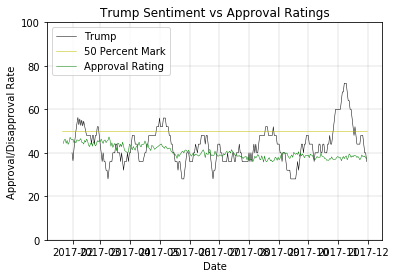

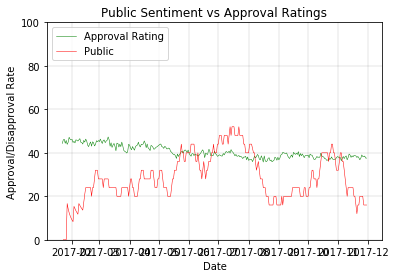

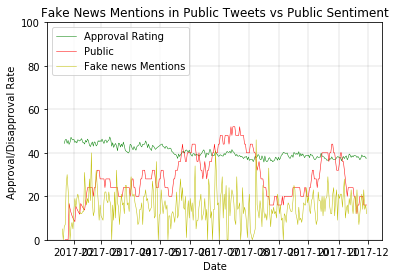

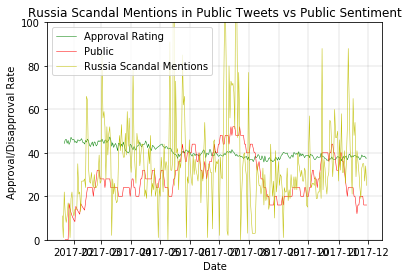

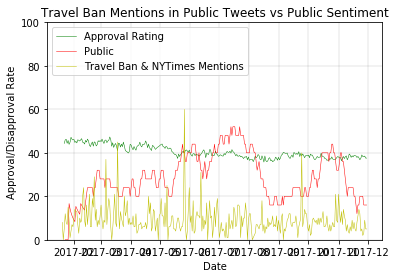

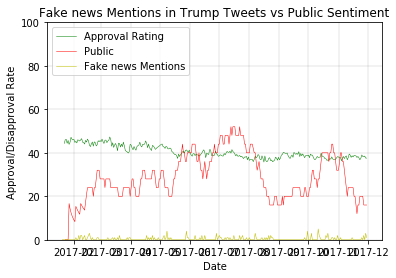

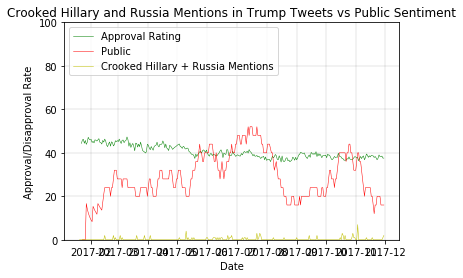

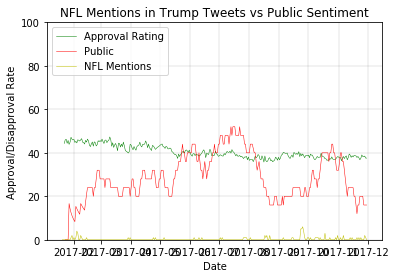

In [345]:
#for key in sorted(xnew.keys()):
#    print "%s : %s" % (key,xnew[key])
plotDF(df,index_track=index_track,data_label="Trump",title="Trump Sentiment vs Approval Ratings")
plotDF(df,_dict_second=all_tweets_index_track,data_second_label="Public",title="Public Sentiment vs Approval Ratings")
#plotDF(df,index_track = index_track, data_label="Trump",_dict_second = all_tweets_index_track,data_second_label="Public",cat_plot=cat_plot)
plotDF(df,_dict_second = all_tweets_index_track,data_second_label="Public",cat_plot=cat_plot,topic="Fake news",title="Fake News Mentions in Public Tweets vs Public Sentiment")
plotDF(df,_dict_second = all_tweets_index_track,data_second_label="Public",cat_plot=cat_plot,topic="Russia Scandal",title="Russia Scandal Mentions in Public Tweets vs Public Sentiment")
plotDF(df,_dict_second = all_tweets_index_track,data_second_label="Public",cat_plot=cat_plot,topic="Travel Ban & NYTimes",title="Travel Ban Mentions in Public Tweets vs Public Sentiment")
plotDF(df,_dict_second = all_tweets_index_track,data_second_label="Public",cat_plot=trump_cat_plot,topic="Fake news",title="Fake news Mentions in Trump Tweets vs Public Sentiment")
plotDF(df,_dict_second = all_tweets_index_track,data_second_label="Public",cat_plot=trump_cat_plot,topic="Crooked Hillary + Russia",title="Crooked Hillary and Russia Mentions in Trump Tweets vs Public Sentiment")
plotDF(df,_dict_second = all_tweets_index_track,data_second_label="Public",cat_plot=trump_cat_plot,topic="NFL",title="NFL Mentions in Trump Tweets vs Public Sentiment")


#print np.mean(x.values())
#tdp = {'day1':['i hate sushi','work with me here','trump is evil','why are you killing me'],'day2':['evil hate dislike shit no bad']}
#print impactForData(tdp)
#print impactForData(tpd)
#tw = ["i hate sushi","i love europe","trump is not good for america","where is my phone?"]
#print impactForList(tw)